In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

import sys,random

%load_ext autoreload
%autoreload 2

sys.path.append('..')
from util import provas,load_padr,score_inep, notas_sisu, params_inep,load_acertos,load_sample


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
sns.set_theme(
    context='notebook',
    style='darkgrid',
    palette='deep',
    font='sans-serif',
    font_scale=1.3,
    color_codes=True,
    rc=None,
)
pd.options.display.float_format = '{:,.2f}'.format

In [40]:
ano = 2023
area = 'MT'
padr = load_acertos(ano,area,10000)
notas = score_inep(padr,ano,area,enemscale=True)

In [53]:
notas.query("nota > 600")

,nota,se
candidato,,
210058736371,879.61,32.92
210061770060,609.57,40.18
210058812363,661.59,28.98
210061863186,637.01,34.48
210062059609,776.42,28.59
...,...,...
210058355509,678.50,30.36
210061760180,615.05,38.96
210060974976,675.71,29.44


<Axes: xlabel='nota', ylabel='nota_inep'>

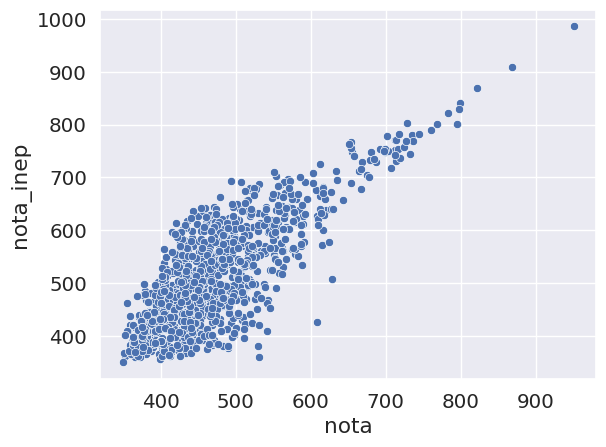

In [23]:
sns.scatterplot(x=notas['nota'],y=padr['nota_inep'])

In [54]:
def enemfig(ano,area):    
    #padr, notas_inep = load_padr(prova,1000,nota_inep=True)
    padr = load_acertos(ano,area,2000)
    notas = score_inep(padr,ano,area,enemscale=True)
    notas = notas.sort_values('nota',ascending=False) 
    divs = []
    centers = []
    div_corrente = 0
    for i,(nota,se) in notas.iterrows():
        if nota-se > div_corrente:
            divs.append(nota-se)
            centers.append(nota)
            div_corrente = nota+se
    divs.append(div_corrente)
    divs = np.array(divs)
    centers = np.array(centers)
    errs = centers - divs[:-1]
    x = list(range(1,len(notas)+1))
    y = notas['nota']
    se = notas['se']
    fig = plt.figure(figsize=(10,7))
    plt.errorbar(x,y,yerr=se,fmt='',errorevery=10,alpha=0.9)
    plt.scatter(x, y,marker=None,s = 0,edgecolor = 'indianred')
    #plt.errorbar(np.zeros(len(centers))-20,centers,yerr=errs,fmt="",elinewidth=5,capsize=20,capthick=5)
    ax = plt.gca()
    ax.set_xticks([1])
    ax.set_ylim(200,1000)
    ax.set_ylabel("Nota ENEM")
    ax.set_xlabel("Ranking dos candidatos")
    notamin = notas['nota'].min()
    notamax = notas['nota'].max()
    notamin = notas['se'].min()
    epmax = notas.iloc[notas['se'].argmax()]
    epmin = notas.iloc[notas['se'].argmin()]
    ax.set_title(f"Notas ENEM {ano} ({area}) em ordem descrescente.\n erro padrão na nota varia de: {epmin['se']:.0f} até {epmax['se']:.0f}")
    return 
interact(enemfig,ano=range(2009,2024),area=['CH','CN','MT']);

interactive(children=(Dropdown(description='ano', options=(2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 201…

In [ ]:
notas = score_inep(padr,ano,area,enemscale=True)

In [33]:
notas.describe()

,nota,se
count,"1,000.00","1,000.00"
mean,476.14,85.00
std,81.29,13.92
min,349.10,26.99
25%,421.94,79.24
50%,458.91,88.52
75%,511.57,93.31
max,950.99,115.81


In [114]:
areawidg = widgets.Dropdown(
    options=['CN','CH','MT'],
    value='CN',
    description='Area:',
)
anowidg = widgets.Dropdown(
    options=range(2023,2008,-1),
    value=2022,
    description='Ano:',
)
faixawdg = widgets.BoundedFloatText(
    value=1,
    min=-1.2,
    max=3,
    step=0.1,
    description='Nota:',
    disabled=False
)

def escolhe_padr(ano=2022,area='CN',faixa=0):
    padr = load_acertos(ano,area,3000,True)
    nota = 500+faixa*100
    nota_inep = padr.iloc[:,-3:]
    nota_inep = nota_inep.query("nota_inep > @nota and nota_inep < @nota + 5")
    nota_inep = nota_inep.sample(1)
    nota = nota_inep['nota_inep'].iloc[0];acertos = nota_inep['acertos'].iloc[0]
    print(f"Acertos = {acertos}, nota INEP = {nota}" )
    index = nota_inep.index[0]
    padr = padr.loc[index:index]
    params = params_inep(ano,area,dropna=True)
    score_mirt_ml = score_inep(padr,ano,area,method="ML",enemscale=False)
    nota_mirt_ml = score_mirt_ml['nota'].iloc[0]
    se_mirt_ml = score_mirt_ml['se'].iloc[0]
    score_mirt_eap = score_inep(padr,ano,area,method="EAP",enemscale=False)
    nota_mirt_eap = score_mirt_eap['nota'].iloc[0]
    se_mirt_eap = score_mirt_eap['se'].iloc[0]

    print(f"Nota ML do mirt = {nota_mirt_ml:.2f} ± {se_mirt_ml:.2f}")
    print(f"Nota EAP do mirt = {nota_mirt_eap:.2f} ± {se_mirt_eap:.2f}")
    params = params.join(padr.T)
    return params

interact(escolhe_padr,ano=anowidg,area=areawidg,faixa=faixawdg)


interactive(children=(Dropdown(description='Ano:', index=1, options=(2023, 2022, 2021, 2020, 2019, 2018, 2017,…

<function __main__.escolhe_padr(ano=2022, area='CN', faixa=0)>

In [121]:

def vero(ano=2022,area='CN',faixa=0,ordem_dificuldade=True,calculate_until=45):

    params = escolhe_padr(ano,area,faixa=faixa)
    params = params.sort_values('b_inep',ascending=ordem_dificuldade)
    i=0

    theta = np.arange(-3,3,0.01)
    lh = np.ones(len(theta))
    
    for item,value in params.iterrows():
    
        if i == calculate_until: 
            print(f"stopped at item {i}")
            break
        i += 1
    
        acertou = int(value.iloc[-1])
        if acertou:
            lh = lh*P(theta,a=value['a_inep'],b=value['b_inep'],c=value['c_inep'])
        else:
            lh = lh*(1-P(theta,a=value['a_inep'],b=value['b_inep'],c=value['c_inep']))

    nota_ml = (-3+lh.argmax()*0.01)
    posterior = lh*norm.pdf(theta)
    nota_eap = np.average(theta, weights=posterior)
    def check(s):
        if s: return '✅'
        else: return '❌'
    params.iloc[:,-1] = params.iloc[:,-1].apply(check)
    params = params.drop(columns=['a_inep','u','c_inep'])
    params = params.transpose()
    params.insert(i,column = '🛑',value=['|>','|>'])
    pd.options.display.float_format = '{:.2f}'.format
    pd.set_option('display.max_columns', 500)
    display(params)
    with sns.axes_style("whitegrid"):
        fig,axs = plt.subplots(1,2,sharex=True,figsize = (16,6))
        ax1 = axs[0]; ax2 = axs[1]
        sns.lineplot(x=theta,y=lh,ax=ax1);
        ax1.set_xlabel(r"$\theta$");ax.set_ylabel(r"$\mathrm{prob}(\vec{x_i}|\theta)$");
        ax1.set_title(f"Máxima verossimilhança: nota = {nota_ml:.3f}");
        sns.lineplot(x=theta,y=posterior,ax=ax2);
        ax2.set_xlabel(r"$\theta$");ax.set_ylabel(r"Posterior");
        ax2.set_title(f"Expected a Posteriori: nota = {nota_eap:.3f}");
        
        plt.grid(axis='y')
    return


interact(vero,ordem_dificuldade=True,calculate_until=range(0,46))

interactive(children=(IntSlider(value=2022, description='ano', max=6066, min=-2022), Text(value='CN', descript…

<function __main__.vero(ano=2022, area='CN', faixa=0, ordem_dificuldade=True, calculate_until=45)>

In [109]:
df23 = load_acertos(2023,'MT')
df23['ano'] = 2023
df19 = load_acertos(2019,'MT')
df19['ano'] = 2019
df16 = load_acertos(2016,'MT')
df16['ano'] = 2016
df17 = load_acertos(2017,'MT')
df17['ano'] = 2017
df11 = load_acertos(2011,'MT')
df11['ano'] = 2011
df13 = load_acertos(2013,'MT')
df13['ano'] = 2013

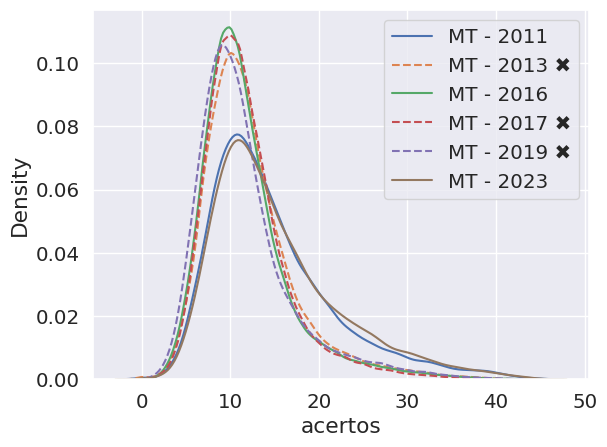

In [114]:
sns.kdeplot(df11,x='acertos',label='MT - 2011')
sns.kdeplot(df13,x='acertos',ls='--',label='MT - 2013 ✖')
sns.kdeplot(df16,x='acertos',label='MT - 2016')
sns.kdeplot(df17,x='acertos',ls='--',label='MT - 2017 ✖')
sns.kdeplot(df19,x='acertos',ls='--',label='MT - 2019 ✖')
sns.kdeplot(df23,x='acertos',label='MT - 2023')
plt.legend()

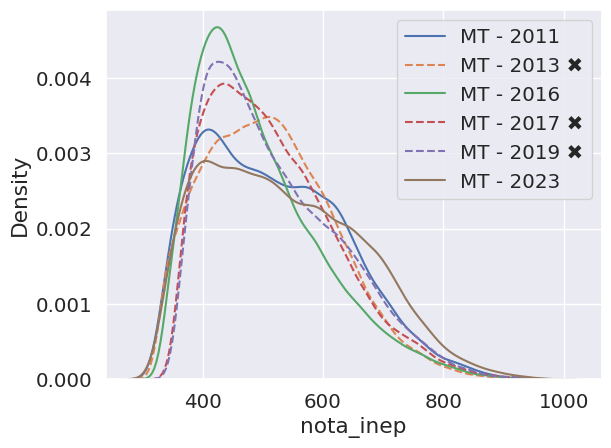

In [115]:
sns.kdeplot(df11,x='nota_inep',label='MT - 2011 ')
sns.kdeplot(df13,x='nota_inep',ls='--',label='MT - 2013 ✖')
sns.kdeplot(df16,x='nota_inep',label='MT - 2016')
sns.kdeplot(df17,x='nota_inep',ls='--',label='MT - 2017 ✖')
sns.kdeplot(df19,x='nota_inep',ls='--',label='MT - 2019 ✖')
sns.kdeplot(df23,x='nota_inep',label='MT - 2023')
plt.legend()

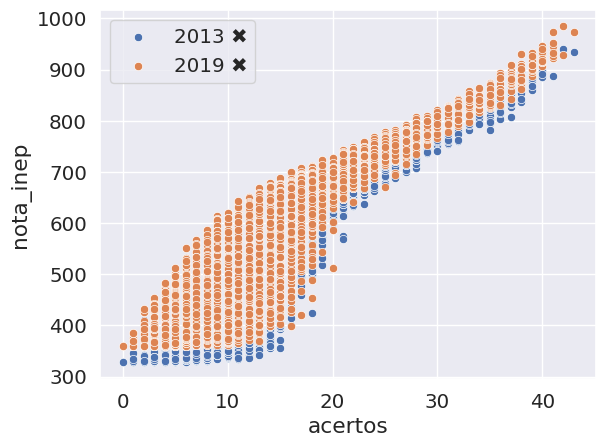

In [105]:
#sns.scatterplot(df11,x='acertos',y='nota_inep',label = '2011')
sns.scatterplot(df13,x='acertos',y='nota_inep',label = '2013 ✖')
sns.scatterplot(df19,x='acertos',y='nota_inep', label = '2019 ✖')
#sns.scatterplot(df23,x='acertos',y='nota_inep', label = '2023')
plt.legend()

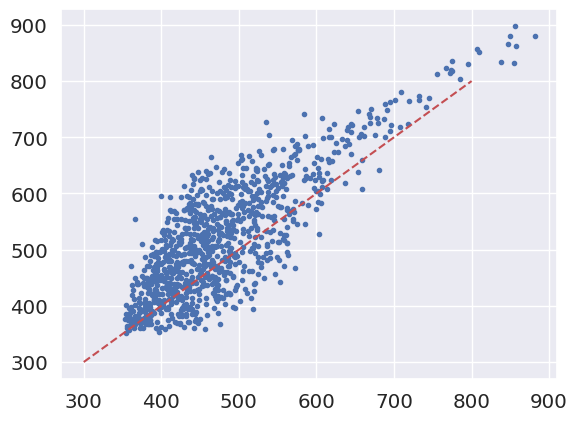

In [123]:
# a função abaixo calcula a nota de uma determinda prova, dado um padrão de resposta
ano = 2017
area = 'MT'
padr = load_acertos(ano,area,1000)
notas_atp = score_inep(padr,ano,area,enemscale=True)
# Vamos comparar o nosso cálculo a partir dos padrões de resposta 
# e os parâmetros IRT dado pelo INEP, com a nota do INEP dado nos microdados.
x = notas_atp['nota']
y = padr['nota_inep']
#y = notas_inep['acertos']

plt.plot(x,y,'.',[300,800],[300,800],'--r');